---
# Práctica 2: Inferencia exacta: ventajas y límites.
Docente: Gustavo Landfried

Inferencia Bayesiana Causal 1

1er cuatrimestre 2025

UNSAM

Alumno: Tomás Pablo Korenblit

----

---
## 1. ¿En qué negocio conviene comprar?

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as st
from scipy.integrate import quad
from statsmodels.api import OLS

from ModeloLineal import moments_posterior
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import seaborn as sns


np.random.seed(16)

In [2]:
negocios = {
            "A":{"k":10,"n":10},
            "B":{"k":48,"n":50},
            "C":{"k":186,"n":200}
           }

In [3]:
# Prior uniforme en (0,1)
def Pp(p):
    return 1

# Verosimilitud binomial
def Pk_np(k, n, p):
    return st.binom.pmf(k, n, p)

---
## 1.1 Interpretación del Galton Board
- Cada obstaculo representa una decision binomial, `{me gusta, no me gusta}`.
- Cada recipiente representa el numero total de `me gusta` posible.
- La cantidad de niveles representa el numero de personas $n_i$ que toman la decision.

---
## 1.2 Graficar el posterior

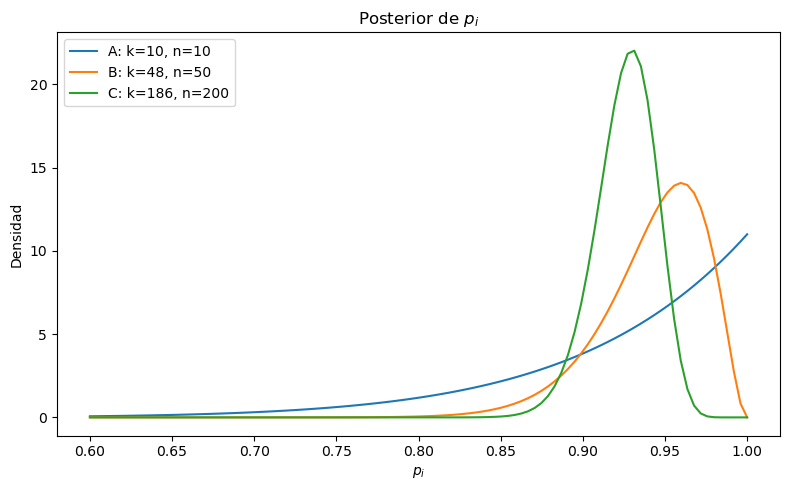

In [4]:
# Posterior beta
def Pp_kn(p, k, n):
    return st.beta.pdf(p, k + 1, n - k + 1)

# Vector de p
p_values = np.linspace(0.6, 1, 100)

# Plot
plt.figure(figsize=(8, 5))

for nombre, datos in negocios.items():
    k, n = datos["k"], datos["n"]
    plt.plot(p_values, Pp_kn(p_values, k, n), label=f"{nombre}: k={k}, n={n}")

plt.title("Posterior de $p_i$")
plt.xlabel("$p_i$")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()

---
## 1.3 Intervalos de credibilidad el posterior

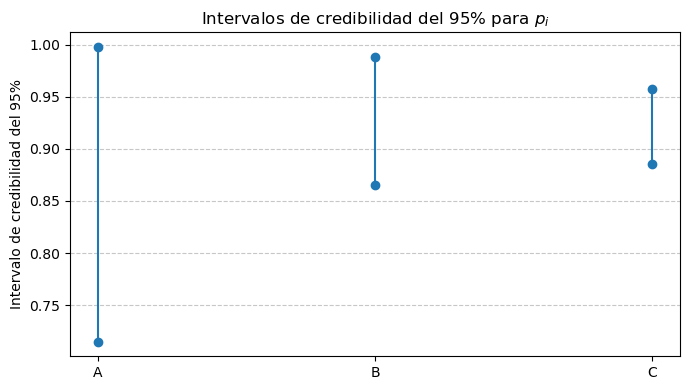

In [5]:
# Calcular intervalos de credibilidad
intervalos = [
    st.beta.interval(0.95, datos["k"] + 1, datos["n"] - datos["k"] + 1)
    for datos in negocios.values()
]

# Etiquetas y posiciones
labels = list(negocios.keys())
x = np.arange(len(labels))

# Graficar
plt.figure(figsize=(7, 4))
for i, (low, high) in enumerate(intervalos):
    plt.plot([i, i], [low, high], marker="o", color="tab:blue")

plt.xticks(x, labels)
plt.ylabel("Intervalo de credibilidad del 95%")
plt.title("Intervalos de credibilidad del 95% para $p_i$")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

---
## 1.4 Elegir dónde comprar

In [6]:
# === Probabilidad marginal de m = 1 ===
prob_marginal_m = []

for nombre, datos in negocios.items():
    k, n = datos["k"], datos["n"]
    integral, _ = quad(lambda p: p * Pp_kn(p, k, n), 0, 1)
    prob_marginal_m.append((nombre, integral))

# Mostrar resultados
for nombre, p in prob_marginal_m:
    print(f"Probabilidad marginal de m=1 para el negocio {nombre}: {p:.3f}")

Probabilidad marginal de m=1 para el negocio A: 0.917
Probabilidad marginal de m=1 para el negocio B: 0.942
Probabilidad marginal de m=1 para el negocio C: 0.926


---
## 2. La puntería de las arqueras mexicanas.
- $x$ = posición del arco
- $y_i$ = posición de la flecha
- $\beta$ = std dev posición de la flecha
- $\sigma$ = std dev posición del arco
- $\mu$ = posición promedio del arco

Posición de la flecha: $$P(y_i|x) = N(y_i|x,\beta^2)$$

Prior sobre la posición del arco: $$P(x) = N(x|\mu,\sigma^2)$$

---
## 2.1 Predicción sobre la posición de la primera flecha


### Aproximación

In [7]:
# Prior sobre x: N(0, 1.5)
def Px(x):
    return st.norm.pdf(x, 0, 1.5)

# Likelihood: y ~ N(x, 1)
def Py_x(y, x):
    return st.norm.pdf(y, x, 1)

# Aproximación de la distribución conjunta P(x, y)
def aproximar_conjunta(rango):
    Z = np.zeros((len(rango), len(rango)))
    for i, x in enumerate(rango):
        for j, y in enumerate(rango):
            Z[j, i] = Py_x(y, x) * Px(x)
    return Z

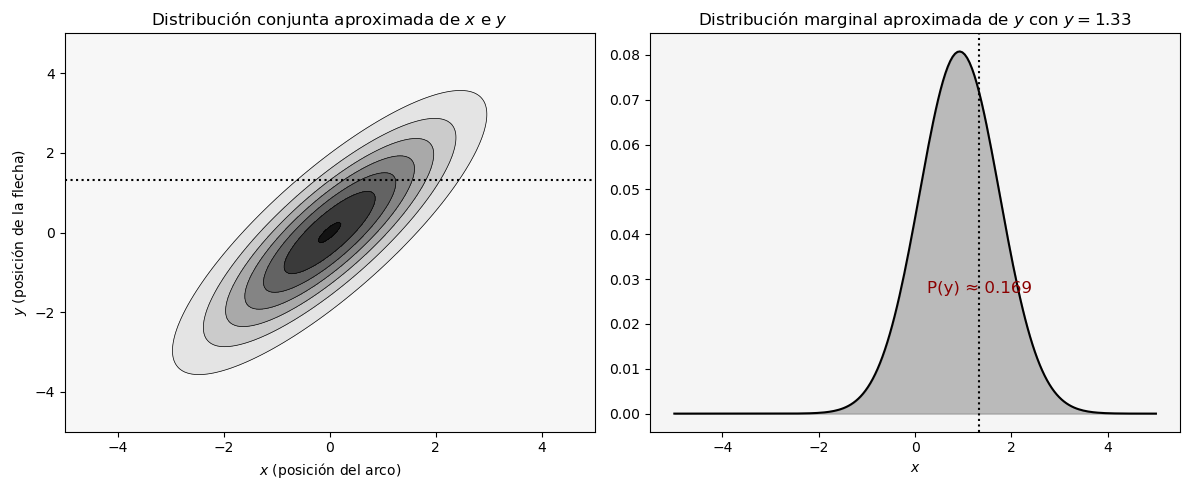

In [8]:
# Rango de evaluación
valores = np.linspace(-5, 5, 200)
Z = aproximar_conjunta(valores)

# Gráfico
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Distribución conjunta aproximada ---
ax[0].contourf(valores, valores, Z, levels=7, cmap="Greys")
ax[0].contour(valores, valores, Z, levels=7, colors="black", linewidths=0.5)

ax[0].set_title("Distribución conjunta aproximada de $x$ e $y$")
ax[0].set_xlabel("$x$ (posición del arco)")
ax[0].set_ylabel("$y$ (posición de la flecha)")

# Línea en y = y_val
y_val = 1.33
i_y = np.abs(valores - y_val).argmin()
ax[0].axhline(y=y_val, color="black", linestyle="dotted")

# --- Distribución marginal aproximada de y ---
Z_y = Z[i_y, :]
ax[1].plot(valores, Z_y, color="black")
ax[1].fill_between(valores, Z_y, color="grey", alpha=0.5)

ax[1].set_title(f"Distribución marginal aproximada de $y$ con $y={y_val}$")
ax[1].set_xlabel("$x$")
ax[1].axvline(x=y_val, color="black", linestyle="dotted")

# Área bajo la curva: P(y) ≈ ∫ p(y|x)p(x) dx
integral, _ = quad(lambda x: Py_x(y_val, x) * Px(x), -5, 5)
ax[1].text(
    y_val,
    max(Z_y) / 3,
    f"P(y) ≈ {integral:.3f}",
    fontsize=12,
    color="darkred",
    ha="center"
)

# Estilo final
ax[0].set_facecolor("whitesmoke")
ax[1].set_facecolor("whitesmoke")
ax[0].grid(False)
ax[1].grid(False)
plt.tight_layout()

Solución exacta

In [9]:
# Cálculo exacto de P(y)
def Py(y):
    return st.norm.pdf(y, 0, np.sqrt(1.5**2 + 1**2))

print(f"P(y={y_val}) aproximada = {integral:.3f}")
print(f"P(y={y_val}) exacta     = {Py(y_val):.3f}")

P(y=1.33) aproximada = 0.169
P(y=1.33) exacta     = 0.169


---
## 2.2 Posterior sobre la posición del arco


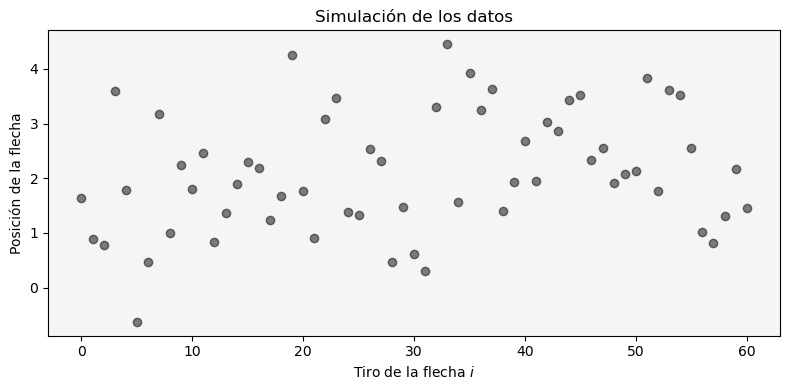

In [10]:
# Parámetros: x ~ N(2, 0.6), y ~ N(x, 1)
posiciones_arco = st.norm.rvs(loc=2, scale=0.6, size=61)
posiciones_flecha = st.norm.rvs(loc=posiciones_arco, scale=1)

# Gráfico de simulación
plt.figure(figsize=(8, 4))
plt.plot(posiciones_flecha, "o", color="black", alpha=0.5)
plt.xlabel("Tiro de la flecha $i$")
plt.ylabel("Posición de la flecha")
plt.title("Simulación de los datos")
plt.grid(False)
plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

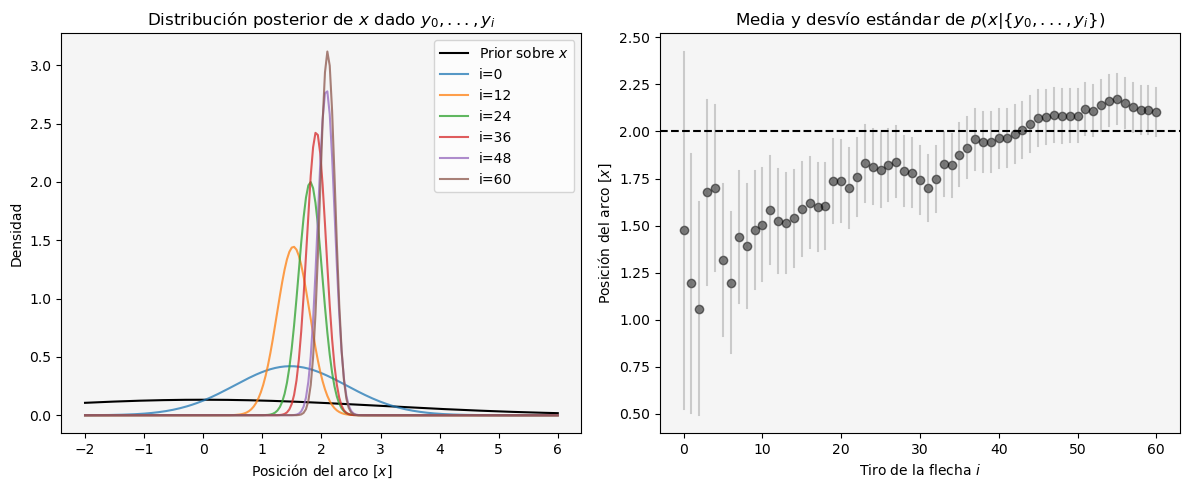

In [11]:
def Px_y(y, mu=0, sigma=3, beta=1):
    """Devuelve los parámetros de la distribución posterior de x dado y"""
    mu_post = (y * sigma**2 + mu * beta**2) / (sigma**2 + beta**2)
    sigma_post = np.sqrt((sigma**2 * beta**2) / (sigma**2 + beta**2))
    return mu_post, sigma_post

# Rango para graficar
x_range = np.linspace(-2, 6, 200)

# Gráficos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Prior inicial sobre x
axs[0].plot(x_range, st.norm.pdf(x_range, loc=0, scale=3),
            label="Prior sobre $x$", color="black")

# Actualización bayesiana secuencial
for i, yi in enumerate(posiciones_flecha):
    # Inicializar con prior si es el primer tiro
    if i == 0:
        mu_post, sigma_post = Px_y(yi)
    else:
        mu_post, sigma_post = Px_y(yi, mu_post, sigma_post)

    # Graficar algunas posteriores seleccionadas
    if i % 12 == 0:
        axs[0].plot(
            x_range,
            st.norm.pdf(x_range, mu_post, sigma_post),
            label=f"i={i}",
            alpha=0.75
        )

    # Media y desviación estándar en función de i
    axs[1].plot(i, mu_post, "o", color="black", alpha=0.5)
    axs[1].plot(
        [i, i],
        [mu_post - sigma_post, mu_post + sigma_post],
        color="dimgray", alpha=0.3
    )

# Línea en la media real de los datos generados
axs[1].axhline(y=2, color="black", linestyle="--")

# Estética
axs[0].legend()
axs[0].set_xlabel("Posición del arco [$x$]")
axs[0].set_ylabel("Densidad")
axs[0].set_title("Distribución posterior de $x$ dado ${y_0, ..., y_i}$")

axs[1].set_ylabel("Posición del arco [$x$]")
axs[1].set_xlabel("Tiro de la flecha $i$")
axs[1].set_title("Media y desvío estándar de $p(x|\{y_0, ..., y_i\})$")

axs[0].set_facecolor("whitesmoke")
axs[1].set_facecolor("whitesmoke")
axs[0].grid(False)
axs[1].grid(False)
plt.tight_layout()
plt.show()

---
## 2.3 Predicción sobre posición de la última flecha


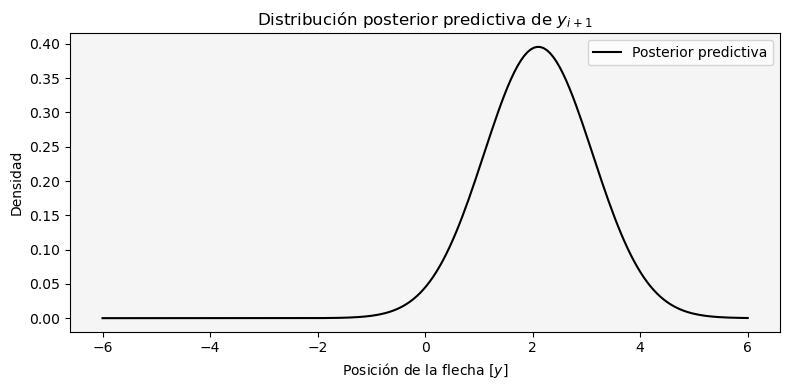

In [12]:
# Posterior final sobre x (después de todos los datos observados)
mu_final, sigma_final = mu_post, sigma_post  # últimos valores tras loop anterior

# Densidad posterior final sobre x
def posterior_x(x):
    return st.norm.pdf(x, mu_final, sigma_final)

# Distribución predictiva de y dado todos los datos (marginalizando x)
def posterior_predictiva_y(y):
    return quad(lambda x: Py_x(y, x) * posterior_x(x), -6, 6)[0]

# Evaluar para un rango de y
y_range = np.linspace(-6, 6, 200)
predictiva = [posterior_predictiva_y(y) for y in y_range]

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(y_range, predictiva, label="Posterior predictiva", color="black")
plt.xlabel("Posición de la flecha [$y$]")
plt.ylabel("Densidad")
plt.title("Distribución posterior predictiva de $y_{i+1}$")
plt.legend()
plt.grid(False)
plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

---
## 3. Modelos polinomiales de complejidad creciente.


---
## 3.1 Generar 20 datos alrededor de una período de una sinoidal

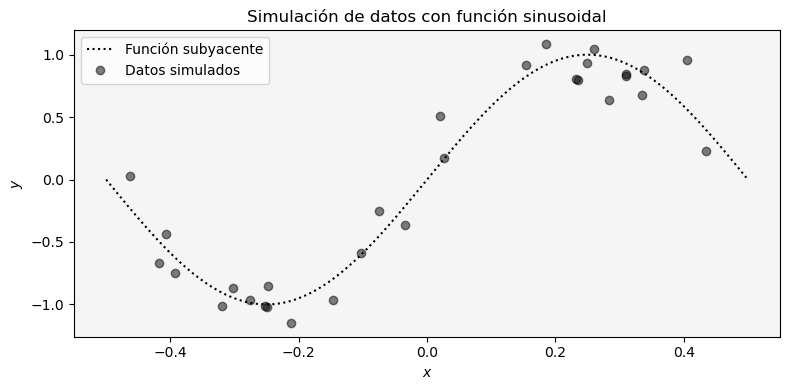

In [13]:
n_obs = 30        # cantidad de observaciones
beta = 0.2        # desviación estándar del ruido
np.random.seed(222)

def f(x):
    return np.sin(2 * np.pi * x)

def simular_datos(f, n, beta, xmin=-0.5, xmax=0.5):
    x = np.random.uniform(xmin, xmax, n)
    y = np.random.normal(loc=f(x), scale=beta)
    return x, y

def graficar_datos(x, y, f, xmin=-0.5, xmax=0.5):
    x_eval = np.linspace(xmin, xmax, 200)
    plt.figure(figsize=(8, 4))
    plt.plot(x_eval, f(x_eval), label="Función subyacente", linestyle="dotted", color="black")
    plt.plot(x, y, "o", label="Datos simulados", color="black", alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Simulación de datos con función sinusoidal")
    plt.legend()
    plt.grid(False)
    plt.gca().set_facecolor("whitesmoke")
    plt.tight_layout()
    plt.show()

x, y = simular_datos(f, n_obs, beta)
graficar_datos(x, y, f)

---
## 3.2 Graficar el valor de máxima verosimilitud obtenido por los modelos polinomiales de grado 0 a 9

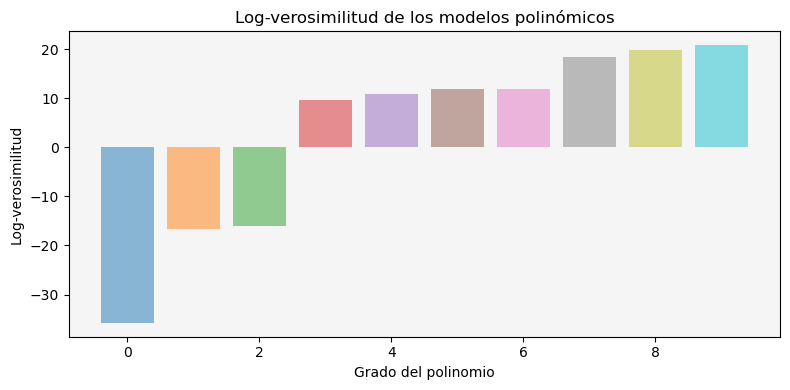

In [14]:
def transformacion_polinomica(x, grado):
    return np.array([x**i for i in range(grado + 1)]).T

fig, ax = plt.subplots(figsize=(8, 4))

for grado in range(10):
    X_poly = transformacion_polinomica(x, grado)
    modelo = OLS(y, X_poly).fit()
    ax.bar(grado, modelo.llf, alpha=0.5, label=f"Grado {grado}")

ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("Log-verosimilitud")
ax.set_title("Log-verosimilitud de los modelos polinómicos")
ax.set_facecolor("whitesmoke")
ax.grid(False)
plt.tight_layout()
plt.show()

---
## 3.3 Graficar las curvas obtenidas con cada modelo mediante máxima verosimilitud.

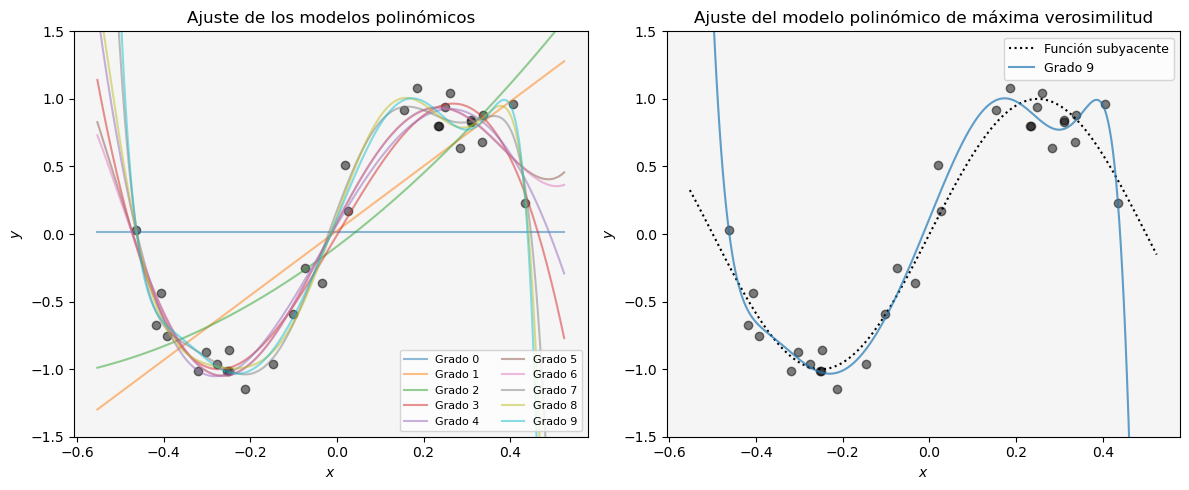

In [15]:
x_min, x_max = x.min(), x.max()
padding = (x_max - x_min) * 0.1
x_range = np.linspace(x_min - padding, x_max + padding, 300)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(x, y, "o", color="black", alpha=0.5)
ax[0].set_ylim(-1.5, 1.5)

ax[1].plot(x_range, f(x_range), color="black", label="Función subyacente", linestyle="dotted")
ax[1].plot(x, y, "o", color="black", alpha=0.5)
ax[1].set_ylim(-1.5, 1.5)

for grado in range(10):
    modelo = OLS(y, transformacion_polinomica(x, grado)).fit()
    y_hat = modelo.predict(transformacion_polinomica(x_range, grado))
    
    ax[0].plot(x_range, y_hat, label=f"Grado {grado}", alpha=0.5)

    if grado == 9:
        ax[1].plot(x_range, y_hat, label="Grado 9", alpha=0.7)

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].set_title("Ajuste de los modelos polinómicos")
ax[0].legend(ncols=2, fontsize=8)
ax[0].set_facecolor("whitesmoke")
ax[0].grid(False)

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].set_title("Ajuste del modelo polinómico de máxima verosimilitud")
ax[1].legend(ncols=1, fontsize=9)
ax[1].set_facecolor("whitesmoke")
ax[1].grid(False)

plt.tight_layout()
plt.show()

---
## 3.4 Evaluación de la predicción “en línea” que hacen los modelos ajustados por máxima verosimilitud.

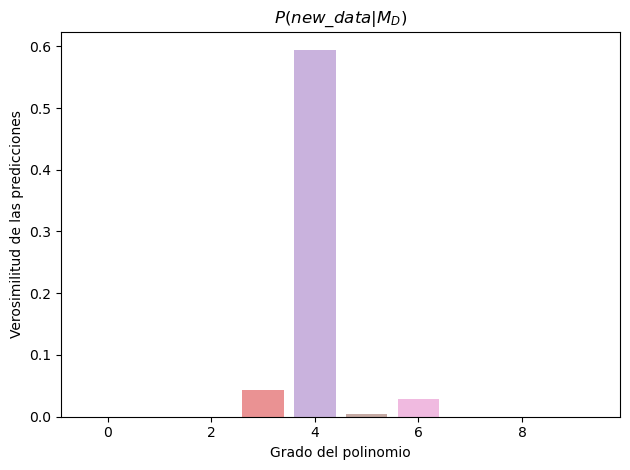

In [16]:
k = 100
x_out_of_sample = st.uniform.rvs(-0.5, 1, k)
y_out_of_sample = st.norm.rvs(loc=f(x_out_of_sample), scale=beta, size=k)

fig, ax = plt.subplots()

for grado in range(10):
    modelo = OLS(y, transformacion_polinomica(x, grado)).fit()
    y_hat = modelo.predict(transformacion_polinomica(x_out_of_sample, grado))

    likelihood_y_hat = np.prod(st.norm.pdf(y_out_of_sample, loc=y_hat, scale=beta))
    ax.bar(grado, likelihood_y_hat, label=f"grado {grado}", alpha=0.5)

ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("Verosimilitud de las predicciones")
ax.set_title("$P(new\_data|M_D$)")
plt.tight_layout()

---
## 3.5 Más criterios arbitrarios de selección de hipótesis: los regularizadores

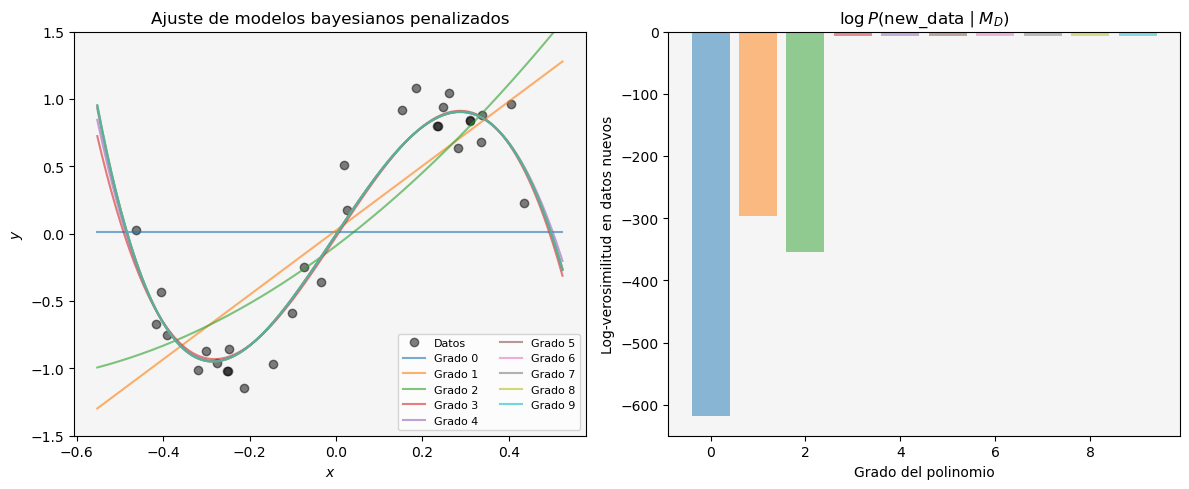

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(x, y, "o", color="black", alpha=0.5, label="Datos")
ax[0].set_ylim(-1.5, 1.5)

for grado in range(10):
    means, cov = moments_posterior(1 / (25)**2, 1, y, transformacion_polinomica(x, grado))

    y_curve = transformacion_polinomica(x_range, grado) @ means
    ax[0].plot(x_range, y_curve, label=f"Grado {grado}", alpha=0.6)

    y_hat = transformacion_polinomica(x_out_of_sample, grado) @ means
    log_likelihood = np.sum(st.norm.logpdf(y_out_of_sample, loc=y_hat, scale=beta))
    ax[1].bar(grado, log_likelihood, alpha=0.5)

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].set_title("Ajuste de modelos bayesianos penalizados")
ax[0].legend(ncols=2, fontsize=8)
ax[0].set_facecolor("whitesmoke")
ax[0].grid(False)

ax[1].set_xlabel("Grado del polinomio")
ax[1].set_ylabel("Log-verosimilitud en datos nuevos")
ax[1].set_title("$\log P(\mathrm{new\\_data} \mid M_D)$")
ax[1].set_facecolor("whitesmoke")
ax[1].grid(False)

plt.tight_layout()
plt.show()

---
## 3.6 El balance natural de las reglas de la probabilidad.

Text(0, 0.5, 'Probabilidad')

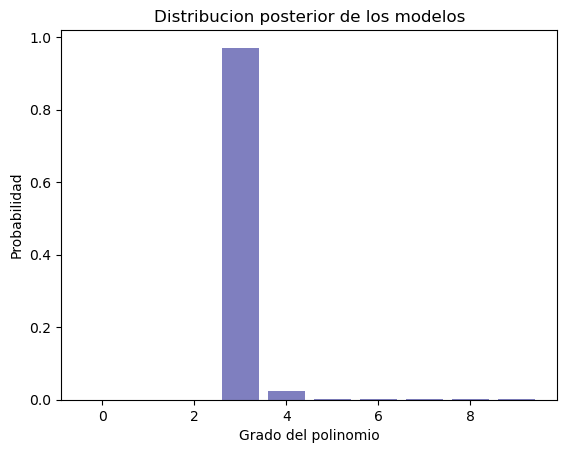

In [18]:
from ModeloLineal import log_evidence

np.random.seed(22)

fig, ax = plt.subplots()

model_log_evidence = [
    log_evidence(y, transformacion_polinomica(x, grado), 1e-6, 10)
    for grado in range(10)
]
model_prior = [1 / 10] * 10
model_posterior = model_prior * np.exp(model_log_evidence)
model_posterior /= np.sum(model_posterior)

ax.bar(range(10), model_posterior, color="navy", label="Posterior", alpha=0.5)
ax.set_title("Distribucion posterior de los modelos")
ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("Probabilidad")

---
## 3.7 Como se explica el balance natural de las reglas de la probabilidad

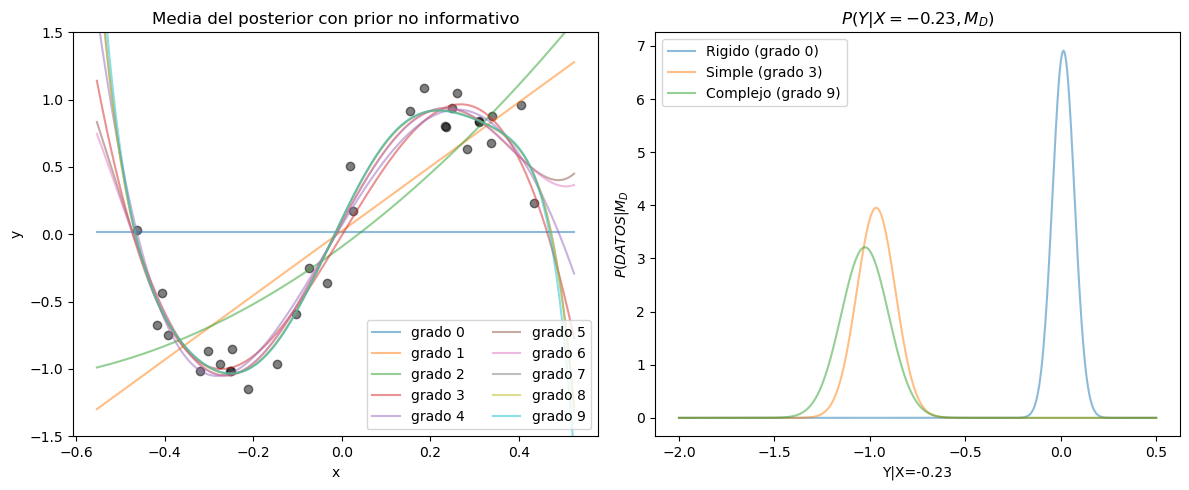

In [19]:
from ModeloLineal import moments_posterior

np.random.seed(22)

x_test = -0.23

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot data
ax[0].plot(x, y, "o", color="black", alpha=0.5)
ax[0].set_ylim(-1.5, 1.5)


_legend = ["Rigido", "Simple", "Complejo"]

for grade in range(10):
    means, cov = moments_posterior(1e-6, 10, y, transformacion_polinomica(x, grade))

    # plot curve
    y_curve = transformacion_polinomica(x_range, grade) @ means
    ax[0].plot(x_range, y_curve, label=f"grado {grade}", alpha=0.5)

    # Plot distribution of the posterior at x = x_test

    if grade in [0, 3, 9]:
        y_test_mean = transformacion_polinomica(x_test, grade) @ means
        y_test_var = (
            transformacion_polinomica(x_test, grade)
            @ cov
            @ transformacion_polinomica(x_test, grade).T
        )
        y_test_sd = np.sqrt(y_test_var)

        y_test_range = np.linspace(-2, 0.5, 500)

        y_test_dist = st.norm.pdf(y_test_range, loc=y_test_mean, scale=y_test_sd)

        ax[1].plot(
            y_test_range,
            y_test_dist,
            label=f"{_legend.pop(0)} (grado {grade})",
            alpha=0.5,
        )


ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Media del posterior con prior no informativo")
ax[0].legend(ncols=2)

ax[1].set_xlabel(f"Y|X={x_test}")
ax[1].set_ylabel("$P(DATOS|M_D$")
ax[1].set_title(f"$P(Y|X={x_test},M_D$)")
ax[1].legend()

plt.tight_layout()

### 4. Efecto causal del sexo biologico sobre la altura


#### 4.1 Abrir el archivo alturas.csv y visualizar los datos


In [20]:
data = pd.read_csv(r"../data/alturas.csv")
data.head()

,id,altura,sexo,contextura_madre,altura_madre
0,1,172.7,M,mediana,159.8
1,2,171.5,M,mediana,160.3
2,3,162.6,F,mediana,160.5
3,4,174.1,M,mediana,159.8
4,5,168.3,M,mediana,158.3


<Axes: xlabel='altura_madre', ylabel='altura'>

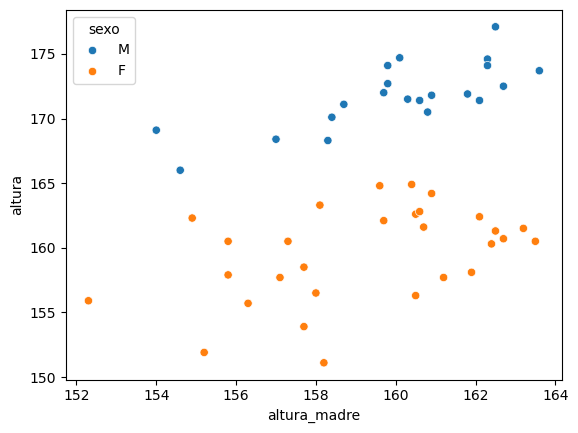

In [23]:
sns.scatterplot(data=data, x="altura_madre", y="altura", hue="sexo")

#### 4.2 Definir los 3 modelos causales alternativos


- modelo base:
  $$altura = h_0 + h_1 . altura\_madre$$

- modelo biologico:
  $$altura = h_0 + h_1 . altura\_madre + h_2 . I(sexo = F) $$

- modelo grupos al azar:
  $$altura = h_0 . altura\_madre + h_{1+(ID mod (max(ID)/2))} $$


#### 4.3 Computar la evidencia de los modelos causales alternativos


In [24]:
np.random.seed(22)

y = data["altura"]

# matriz de diseño modelo base
X0 = np.array([np.ones(len(y)), data["altura_madre"]]).T

# matriz de diseño modelo biologico
X1 = np.array(
    [np.ones(len(y)), data["altura_madre"], (data["sexo"] == "M").astype(int)]
).T

# matriz de diseño modelo de grupos al azar
N = len(y)

grupos = np.zeros((N, N // 2))
indices = np.random.permutation(N)

for i, idx in enumerate(indices):
    grupos[idx, i // 2] = 1

X2 = np.hstack([data["altura_madre"].values.reshape(-1, 1), grupos])

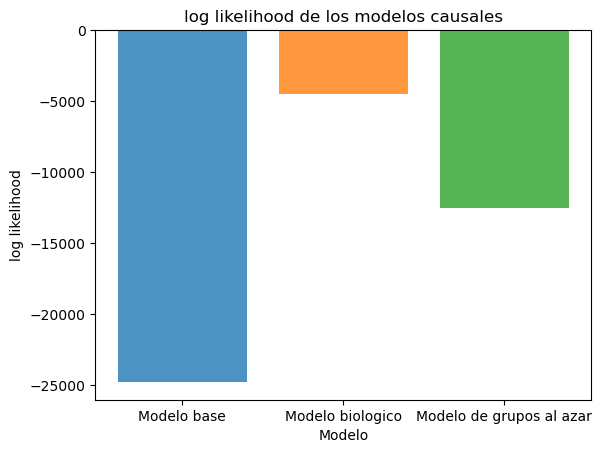

In [25]:
fig, ax = plt.subplots()

_legend = ["Modelo base", "Modelo biologico", "Modelo de grupos al azar"]
ax.set_xlabel("Modelo")
ax.set_xticks(range(len(_legend)))
ax.set_xticklabels(_legend)
ax.set_ylabel("log likelihood")
ax.set_title("log likelihood de los modelos causales")

log_evidence_mj = []
for i, X in enumerate([X0, X1, X2]):
    # alpha "chico" -> prior poco informatico
    # beta "grande" -> ruido en el observable bajo.
    log_evidence_i = log_evidence(y, X, 1e-6, 25)
    log_evidence_mj.append(log_evidence_i)
    ax.bar(i, log_evidence_i, label=_legend[i], alpha=0.8)

#### 4.4. Computar la media geometrica de los modelos causales alternativos


In [26]:
# GeoMean_M  = ( P(D∣M) ) ** 1/N = exp( log_evidence / N )

for i, ll in enumerate(log_evidence_mj):
    geomean = np.exp(ll / len(y))
    print(f"{_legend[i]} - Media Geometrica: {geomean:.2e}")

Modelo base - Media Geometrica: 4.90e-216
Modelo biologico - Media Geometrica: 9.77e-40
Modelo de grupos al azar - Media Geometrica: 7.91e-110


#### 4.5. Computar el posterio de los modelos causales alternativos


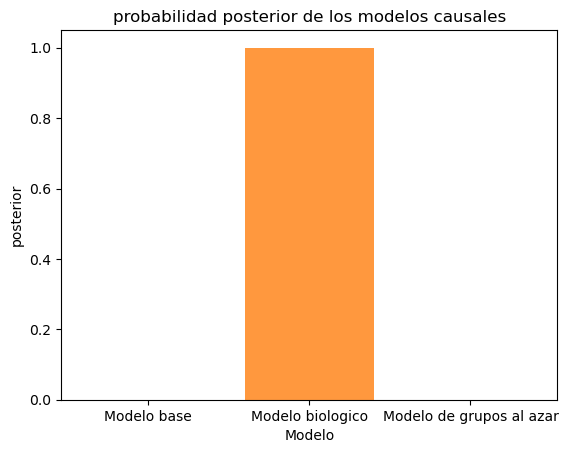

In [27]:
log_prior_m = np.log(np.array([1 / 3] * 3))

log_posterior_m = log_prior_m + np.array(log_evidence_mj)
log_posterior_m -= np.logaddexp.reduce(log_posterior_m)


fig, ax = plt.subplots()
ax.set_xlabel("Modelo")
ax.set_xticks(range(len(_legend)))
ax.set_xticklabels(_legend)
ax.set_ylabel("posterior")
ax.set_title("probabilidad posterior de los modelos causales")

for i, lp in enumerate(log_posterior_m):
    ax.bar(_legend[i], np.exp(lp), label=_legend[i], alpha=0.8)

### 5. Modelos AcausaB y BcausaA


#### 5.1 Generar datos con AcausaB


Text(0.5, 1.0, 'Histograma de los datos generados')

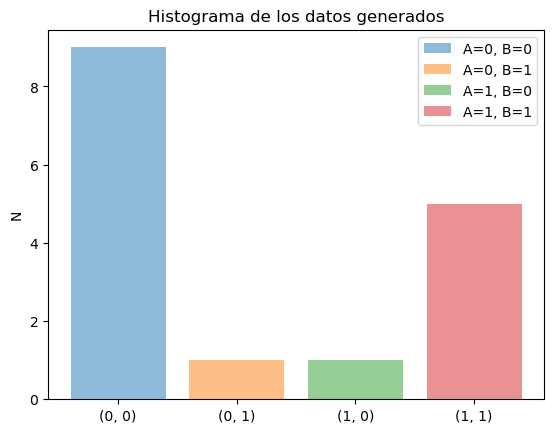

In [28]:
def gen_acausab(n=1):
    _a = st.bernoulli.rvs(0.5, size=n)
    _b = st.bernoulli.rvs(0.95 * _a + 0.05 * (1 - _a))
    return list(zip(_a, _b))


np.random.seed(22)
data = gen_acausab(16)

results = [(i, j) for i in [0, 1] for j in [0, 1]]
_ticks = [str(x) for x in results]

fig, ax = plt.subplots()

for i, r in enumerate(results):
    count = data.count(r)
    ax.bar(
        _ticks[i],
        count,
        label=f"A={r[0]}, B={r[1]}",
        alpha=0.5,
    )

plt.legend()
plt.ylabel("N")
plt.title("Histograma de los datos generados")

#### 5.2 Evaluar el desempeño predictivo de los modelos causales alternativos sobre los datos sinteticos generados


In [29]:
# Para ambos modelos es identica. En general ambos modelos tienen la misma distribucion conjunta.
def likelihood_i(ai, bi):
    return 0.95 if ai == bi else 0.05


def likelihood_model_1(data):
    return np.prod([likelihood_i(ai, bi) for ai, bi in data])


def likelihood_model_2(data):
    return np.prod([likelihood_i(ai, bi) for ai, bi in data])


likelihood = np.array([likelihood_model_1(data), likelihood_model_2(data)])

print(f"likelihood modelo 1: {likelihood_model_1(data):.3e}")
print(f"likelihood modelo 2: {likelihood_model_2(data):.3e}")

likelihood modelo 1: 1.219e-03
likelihood modelo 2: 1.219e-03


#### 5.3 Actualizar creencias respecto de los modelos causales alternativos luego de ver los datos


In [30]:
# prior uniforme sobre ambos modelos
prior = np.array([0.5, 0.5])
posterior = prior * likelihood
posterior /= np.sum(posterior)

print(f"posterior modelo 1: {posterior[0]:.3f}")
print(f"posterior modelo 2: {posterior[1]:.3f}")

# Como ambos modelos tienen la misma distribucion conjunta, ver datos no cambia la probabilidad relativa de que uno sea cierto por sobre el otro.
# Por lo tanto no aprendo nada, es decir posterior = prior

posterior modelo 1: 0.500
posterior modelo 2: 0.500


### 5.4 Dar sus conclusiones.


In [31]:
# Como ambos modelos tienen la misma distribucion conjunta, observar mas datos no cambia la probabilidad relativa de un modelo sobre el otro.
# Es decir que no "aprendo" nada de las observaciones y el posterior es igual al prior.